In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

In [2]:
processed_data_file = '1_processed_data'
os.path.exists(processed_data_file)

True

In [3]:
tot_train_df = pd.read_csv(processed_data_file+'/train_PCA_data.csv',index_col=0)

In [4]:
tot_train_df.head()

,cycle,s2,s3,s4,s7,s11,s12,s15,RUL,HI
id,,,,,,,,,,
1,1,-0.934031,-0.518202,-0.815417,0.909791,-0.889393,1.011533,-0.829887,191,-2.246080
1,2,-0.928596,-0.523217,-0.821319,0.906845,-0.898700,1.004192,-0.833643,190,-2.249248
1,3,-0.918112,-0.532695,-0.832544,0.901018,-0.916229,0.989628,-0.840494,189,-2.254698
1,4,-0.903251,-0.545631,-0.848009,0.892464,-0.939992,0.968152,-0.849236,188,-2.260837
1,5,-0.884803,-0.560742,-0.866250,0.881470,-0.967400,0.940388,-0.858336,187,-2.265682


In [63]:
tot_cycles = pd.DataFrame([len(tot_train_df.loc[i]) for i in tot_train_df.index.unique()],columns =['tot_cycle'])
tot_cycles['rul_label'] = pd.DataFrame(pd.qcut(tot_cycles['tot_cycle'],4, labels=['1','2','3','4']))
tot_cycles.index = tot_train_df.index.unique()#range(1,101)

In [64]:
tot_cycles.head()

,tot_cycle,rul_label
id,,
1,192,2
2,287,4
3,179,2
4,189,2
5,269,4


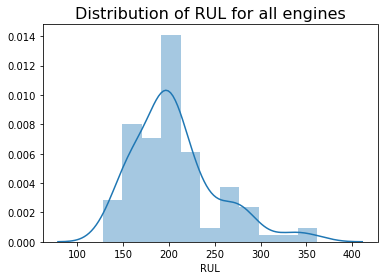

In [57]:
#ax=sns.distplot(rul_y)
ax=sns.distplot(tot_cycles['tot_cycle'])
ax.set_title('Distribution of RUL for all engines',{'fontsize':16});
ax.set_xlabel('RUL');

In [58]:
random_state = 1
tot_train_id = tot_train_df.index.unique()
# stratify 按照数据分布进行划分
train_id, test_id = train_test_split(tot_train_id, test_size = 0.2, random_state=random_state, stratify = tot_cycles['rul_label'])
train_df = tot_train_df.loc[train_id]
test_df = tot_train_df.loc[test_id]

In [59]:
train_id

Int64Index([ 10,   6,  93,  44,  84,  92,  34,  12,  23,  78,  27,  90,  54,
             33,  19,  13,  18,  71,  58,  73,  35,  15,  79,   3,  56,  75,
             96,   8,  87,   9,   1,  86,  37,  63,  22,   5,  25,  50,  72,
             82,  51,  61,  40,  88,  47,   7,  21,  98,  52,  53,  95,  57,
             28,  68,   2,  30,  67,   4,  83,  81,  60,  69,  38,  77,  91,
             66,  89,  94,  26,  62,  99, 100,  64,  74,  85,  65,  59,  49,
             70,  46],
           dtype='int64', name='id')

In [60]:
test_id

Int64Index([11, 20, 17, 41, 42, 97, 80, 45, 48, 39, 36, 14, 31, 43, 29, 76, 16,
            55, 32, 24],
           dtype='int64', name='id')

In [62]:
tot_cycles.loc[test_id]

,tot_cycle,rul_label
id,,
11,240,4
20,234,4
17,276,4
41,216,3
42,196,2
97,202,3
80,185,2
45,158,1
48,231,4


In [76]:
# pick a large window size of 50 cycles

# function to reshape features into (samples, time steps, features) 
# 生成特征样本
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones 
    只有比时间窗口大的序列会被提取特征，若测试样本的时间序列过小，则被忽视。
    另一种方法是对序列进行填充
    """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values # 获得对应列的值
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 141 191 -> from row 141 to 191
    
    # zip将数据打包为元组的列表
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :].flatten() #yield 相当于返回

In [77]:
sequence_length = 50 #设置时间窗口大小
sequence_cols = ['HI']#设置特征(18)

In [78]:
# TODO for debug 
# 样例测试
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 18 columns)
val=list(gen_sequence(tot_train_df.loc[1], sequence_length, sequence_cols))
print(len(val))

142


In [95]:
win_size = 30
selected_ftr_name = ['HI']
X_train =  np.array(list(gen_sequence(tot_train_df.loc[train_id], win_size, selected_ftr_name)) )
X_valid = np.array(list(gen_sequence(tot_train_df.loc[test_id], win_size, selected_ftr_name)) )

In [101]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [107]:

#label_gen = 
y_train = np.array(list(gen_labels(tot_train_df.loc[train_id], win_size, ['RUL'])) ).ravel()
y_valid = np.array(list(gen_labels(tot_train_df.loc[test_id], win_size, ['RUL'])) ).ravel()

In [106]:
y_train.ravel()

array([191, 190, 189, ...,   2,   1,   0], dtype=int64)

In [5]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

In [115]:
svr.best_params_

{'C': 10.0, 'gamma': 0.1}

In [108]:
t0 = time.time()
#训练
svr.fit(X_train, y_train)
svr_fit = time.time() - t0

In [109]:

t0 = time.time()
#测试
y_svr = svr.predict(X_valid)
svr_predict = time.time() - t0


In [113]:
np.sqrt(sum((y_svr - y_valid)**2))

1841.4660959658122

In [116]:
import pickle 
f = open('saved_model/svr.pickle','wb')
pickle.dump(svr, f)
f.close()

In [117]:
f = open('saved_model/svr.pickle','rb')
clf = pickle.load(f)
f.close()

In [118]:
clf.best_params_

{'C': 10.0, 'gamma': 0.1}

In [ ]:
cut_percents = [0.5,0.7,0.9]
res_info_col = ['on_id','on_seg','y_pred','y_true']
res_df = pd.DataFrame(columns=res_info_col)
for on_id in test_id:
    n_seg = len(test_df.loc[on_id])
    for cut_per in cut_percents:
        cur_seg = int(n_seg * cut_per/10)*10 - on_win_size
        tmp_df = eu_dist_df[(eu_dist_df['on_id']==on_id) &(eu_dist_df['on_seg']==cur_seg)].sort_values(by='dist')[:k]
        tmp_rul = sum(tmp_df['his_RUL']*np.exp(-alpha * tmp_df['dist'])/sum(np.exp(-alpha * tmp_df['dist'])))
        #print(cur_seg,tmp_rul, cur_seg+tmp_rul, n_seg - cur_seg - on_win_size)
        res_df= res_df.append(pd.DataFrame([[on_id, cur_seg, tmp_rul, n_seg -cur_seg - on_win_size]],columns = res_info_col))
eu_score += [(k, alpha, RHS_score( res_df['y_true'], res_df['y_pred'])/len(res_df['y_pred']))]